In [2]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist.floating_axes as floating_axes
import mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist.grid_finder import MaxNLocator
from matplotlib.transforms import Affine2D

%matplotlib notebook
import sys
sys.path.insert(0, "/scratch/ierez/IGMCosmo/VoidFinder/python/")
#from voidfinder.voidfinder_functions import xyz_to_radecz
#Use kernel Python 3 (3.7.1) 
from astropy import constants as const
from astropy.table import Table

import os
from astropy.io import fits
in_directory='/scratch/sbenzvi_lab/boss/dr16/delta_fields/'
os.chdir(in_directory)
#from .table_functions import to_array

# Data files

### Galaxies

In [4]:
data_directory = '/scratch/sbenzvi_lab/boss/dr16/delta_fields/'

# Original SDSS DR7 (KIAS-VAGC)
dr7_filename = data_directory + 'deltafields_RAadded90.fits'

# Downsampled SDSS DR7 (to match SDSS LOWZ)
downDR7_filename = data_directory + 'quasars.fits'

### Voids

In [5]:
#void_directory = ''

# Original DR7 voids
dr7void_filename = '/scratch/ierez/IGMCosmo/VoidFinder/outputs/delta_runsdeltafields_added90_fixed._comoving_holes_noMagCut.txt'

# Downsampled SDSS DR7 voids
downDR7void_filename = '/scratch/ierez/IGMCosmo/VoidFinder/outputs/delta_runsdeltafields_added90_fixed._comoving_maximal_noMagCut.txt'

# Import data

### Galaxies

In [6]:
dr7_galaxies = fits.open(dr7_filename)  
dr7_galaxies = Table(dr7_galaxies[1].data)

dr7LOWZ_galaxies = fits.open(downDR7_filename)  
dr7LOWZ_galaxies = Table(dr7LOWZ_galaxies[1].data)

# Original SDSS DR7
dr7_galaxies= Table.read(dr7_filename, 
                          format='ascii.commented_header', 
                          include_names=['ra', 'dec', 'redshift', 'Rgal', 'rabsmag'])

# Downsampled SDSS DR7
dr7LOWZ_galaxies = Table.read(downDR7_filename, 
                              format='ascii.commented_header', 
                              include_names=['ra', 'dec', 'redshift', 'Rgal', 'rabsmag'])

##### Reduce original DR7 to magnitude-limited survey

mag_cut = dr7_galaxies['rabsmag'] <= -20
z_cut = dr7_galaxies['redshift'] < 0.1026

vollim_dr7_galaxies = dr7_galaxies[np.logical_and(mag_cut, z_cut)]

### Voids

In [7]:
# Original DR7 voids
dr7_voids = Table.read(dr7void_filename, format='ascii.commented_header')

# Downsampled SDSS DR7 voids
dr7LOWZ_voids = Table.read(downDR7void_filename, format='ascii.commented_header')
dr7LOWZ_voids[0:5]
dr7_voids[0:5]

x,y,z,radius,flag
float64,float64,float64,float64,int64
-2515.42124464839,2885.946757228773,-16.42206829896108,45.4095805765128,0
-2781.999251278872,3174.6785755458645,-12.387618442482179,44.833192621207964,1
-2718.7345299884423,3106.7495724128507,-10.825927230149468,41.01574251985375,2
-2718.556406466175,3107.7353498611233,-10.46833009713479,40.23975267737992,2
-2771.853255654397,3181.019731295694,4.83119397228613,39.79723217561291,1


##### Convert x,y,z to ra,dec,z for voids

In [8]:
def to_array(table):
    '''Convert table to numpy array'''

    array = np.array([table['x'], table['y'], table['z']])
    array = array.T

    return array
#dr7_voids = xyz_to_radecz(dr7_voids)
#dr7LOWZ_voids = xyz_to_radecz(dr7LOWZ_voids)
#It really is not there.
RtoD = 180./np.pi
DtoR = np.pi/180.
sphere_table=dr7_voids
r = np.linalg.norm(to_array(sphere_table), axis=1)
sphere_table['r'] = r.T
sphere_table['ra'] = np.arctan(sphere_table['y']/sphere_table['x'])*RtoD
sphere_table['dec'] = np.arcsin(sphere_table['z']/sphere_table['r'])*RtoD

# Adjust ra value as necessary                                                                  
boolean = np.logical_and(sphere_table['y'] != 0, sphere_table['x'] < 0)
sphere_table['ra'][boolean] += 180.
dr7_voids=sphere_table

# Convert redshift to distance

Going to plot $cz$ in km/s

In [9]:
c = const.c.to('km/s').value

dr7_galaxies['cz'] = c*dr7_galaxies['z']
dr7LOWZ_galaxies['cz'] = c*dr7LOWZ_galaxies['z']

# Function to set up axes

Following function from declination_slice.ipynb

In [10]:
def setup_axes3(fig, rect, ra0, ra1, cz0, cz1):
    
    # rotate a bit for better orientation
    tr_rotate = Affine2D().translate(-90, 0)
    
    # scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180, 1)

    tr = tr_rotate + tr_scale + mpl.projections.PolarAxes.PolarTransform()
    
    grid_locator1 = angle_helper.LocatorHMS(4)
    tick_formatter1 = angle_helper.FormatterHMS()
    
    grid_locator2 = MaxNLocator(3)
    
    grid_helper = floating_axes.GridHelperCurveLinear(tr, extremes=(ra0, ra1, cz0, cz1),
                                                      grid_locator1=grid_locator1,
                                                      grid_locator2=grid_locator2,
                                                      tick_formatter1=tick_formatter1,
                                                      tick_formatter2=None)

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    fig.add_subplot(ax1)
    
    # adjust axis
    ax1.axis['left'].set_axis_direction('bottom')
    
    ax1.axis['right'].set_axis_direction('top')
    
    ax1.axis['bottom'].set_visible(False)
    
    ax1.axis['top'].set_axis_direction("bottom")
    ax1.axis['top'].toggle(ticklabels=True, label=True)
    ax1.axis['top'].major_ticklabels.set_axis_direction("top")
    ax1.axis['top'].label.set_axis_direction("top")
    
    #ax1.axis['left'].major_ticklabels.set_axis_direction('right')
    ax1.axis["left"].label.set_text("cz [km/s]")
    
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch  
    ax1.patch.zorder = 0.9  

    return ax1, aux_ax

# Wedge plot

In [11]:
# 'd' is declination and 's' is the thickness of the declination slice
# Vary 'd' and 's' to get different slices
d, s = 26, 2

# slice center, can use this for analysis since the slice thickness is very small
slice_ = d + 0.5*s

### Remove galaxies outside declination range

In [12]:
vollim_dr7_galaxies=dr7_galaxies
dr7_dec_cut = np.logical_and(dr7_galaxies['dec'] > d, 
                             dr7_galaxies['dec'] <= d + s)

dr7LOWZ_dec_cut = np.logical_and(dr7LOWZ_galaxies['dec'] > d, 
                                 dr7LOWZ_galaxies['dec'] <= d + s)

vollim_dr7_dec_cut = np.logical_and(vollim_dr7_galaxies['dec'] > d, 
                                    vollim_dr7_galaxies['dec'] <= d + s)

dr7_dec_slice = dr7_galaxies[dr7_dec_cut]
dr7LOWZ_dec_slice = dr7LOWZ_galaxies[dr7LOWZ_dec_cut]
vollim_dr7_dec_slice = vollim_dr7_galaxies[vollim_dr7_dec_cut]

### Remove galaxies outside distance range

In [13]:
cz_min, cz_max = 0, c*max(dr7LOWZ_galaxies['z'])

dr7_dist_boolean = np.logical_and(dr7_dec_slice['cz'] > cz_min, 
                                  dr7_dec_slice['cz'] <= cz_max)

dr7LOWZ_dist_boolean = np.logical_and(dr7LOWZ_dec_slice['cz'] > cz_min, 
                                      dr7LOWZ_dec_slice['cz'] <= cz_max)

vollim_dr7_dist_boolean = np.logical_and(vollim_dr7_dec_slice['cz'] > cz_min, 
                                         vollim_dr7_dec_slice['cz'] <= cz_max)

dr7_sample = dr7_dec_slice[dr7_dist_boolean]
dr7LOWZ_sample = dr7LOWZ_dec_slice[dr7LOWZ_dist_boolean]
vollim_dr7_sample = vollim_dr7_dec_slice[vollim_dr7_dist_boolean]

### Voids that intersect the slice

In [14]:
dr7_dec_intersect_cut = np.sin(np.abs(slice_ - dr7_voids['dec'])*np.pi/180)*dr7_voids['r'] <= dr7_voids['radius']
dr7LOWZ_dec_intersect_cut = np.sin(np.abs(slice_ - dr7LOWZ_voids['dec'])*np.pi/180)*dr7LOWZ_voids['r'] <= dr7LOWZ_voids['radius']

dr7_void_sample = dr7_voids[dr7_dec_intersect_cut]
dr7LOWZ_void_sample = dr7LOWZ_voids[dr7LOWZ_dec_intersect_cut]

# Radius of void at intersection
dr7_void_sample['radius_intersect'] = np.sqrt(dr7_void_sample['radius']**2 
                                              - (np.sin(np.abs(slice_ - dr7_void_sample['dec'])*np.pi/180)*dr7_void_sample['r'])**2)

dr7LOWZ_void_sample['radius_intersect'] = np.sqrt(dr7LOWZ_void_sample['radius']**2 
                                                  - (np.sin(np.abs(slice_ - dr7LOWZ_void_sample['dec'])*np.pi/180)*dr7LOWZ_void_sample['r'])**2)

<IPython.core.display.Javascript object>


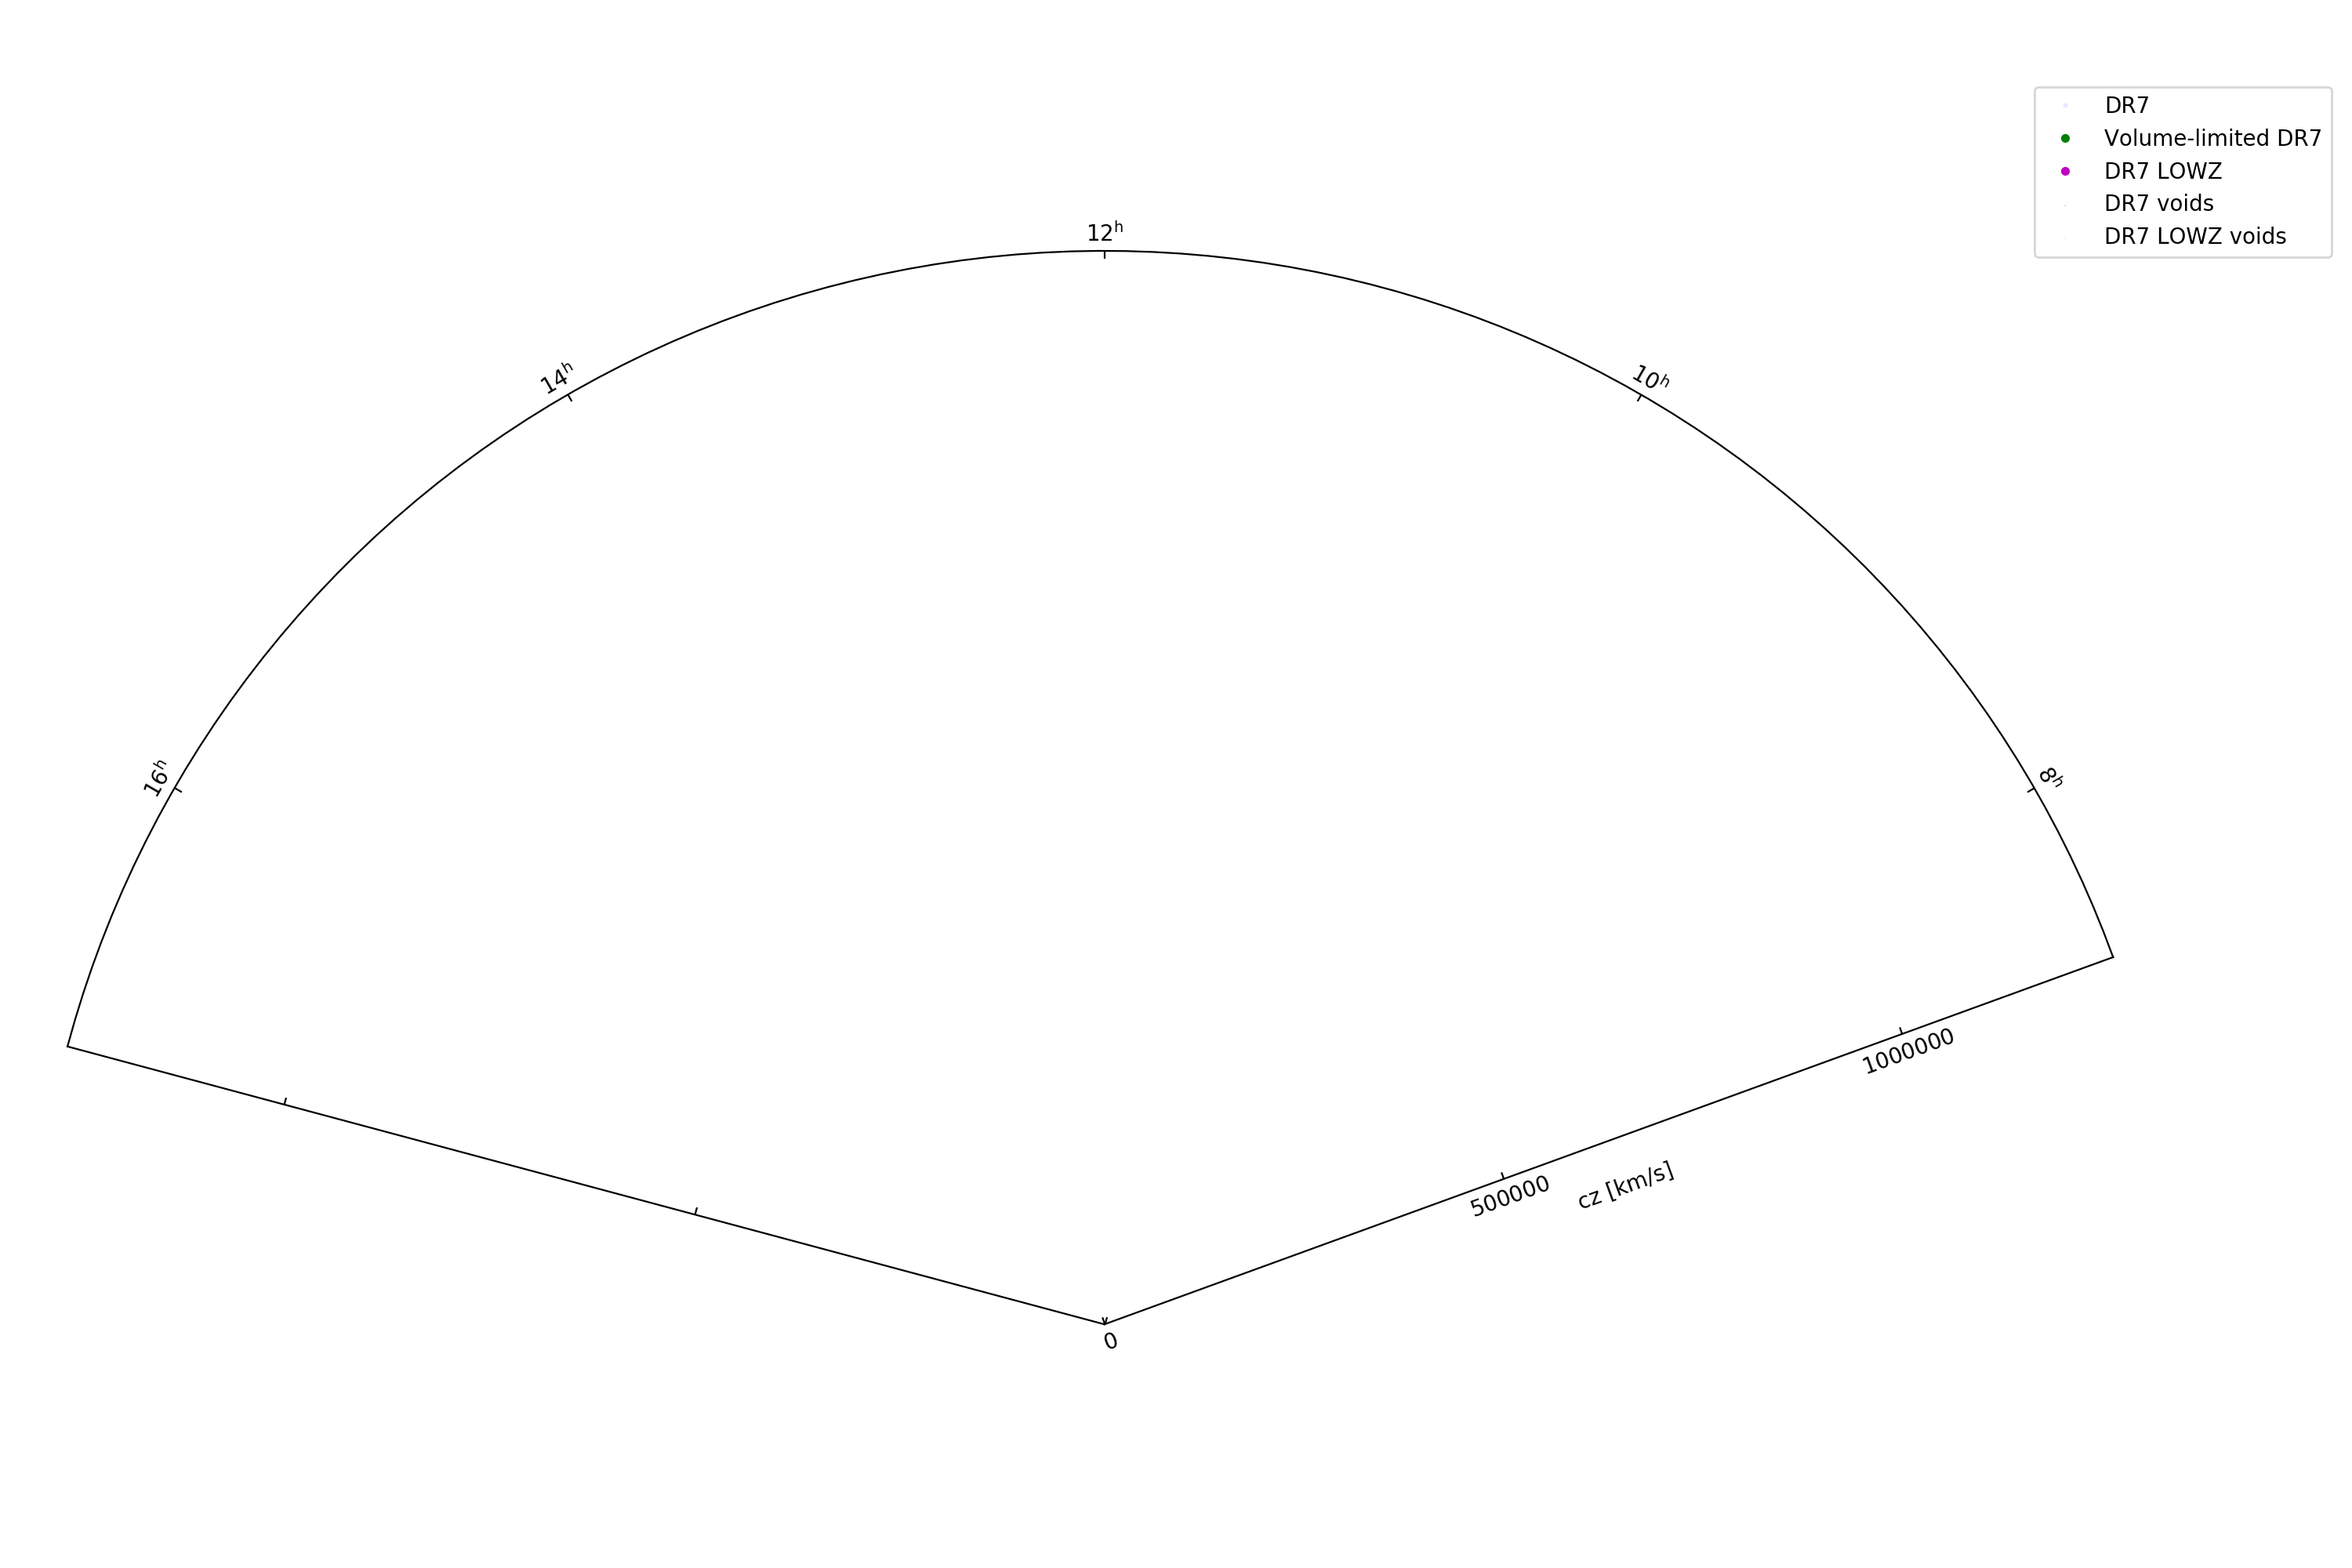

In [15]:
fig = plt.figure(figsize=(15,10))

# Range of ra to use in plot
ra_min, ra_max = 110, 255

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Original DR7 galaxies
aux_ax.plot(dr7_sample['ra'], dr7_sample['cz'], 
            '.', c='b', alpha=0.05, ms=3, zorder=1, label='DR7')

# Volume-limited DR7 galaxies
aux_ax.plot(vollim_dr7_sample['ra'], vollim_dr7_sample['cz'], 
            '.', c='g', zorder=2, label='Volume-limited DR7')

# Downsampled DR7 galaxies
aux_ax.plot(dr7LOWZ_sample['ra'], dr7LOWZ_sample['cz'], 
            '.', c='m', zorder=3, label='DR7 LOWZ')

# Original voids
aux_ax.scatter(dr7_void_sample['ra'], dr7_void_sample['r']*100, 
               s=dr7_void_sample['radius_intersect']*100, 
               edgecolors='none', facecolors='b', alpha=0.1, 
               zorder=4, label='DR7 voids')

# Downsampled voids
aux_ax.scatter(dr7LOWZ_void_sample['ra'], dr7LOWZ_void_sample['r']*100, 
               s=dr7LOWZ_void_sample['radius_intersect']*100, 
               edgecolors='none', facecolors='tab:orange', alpha=0.1, 
               zorder=5, label='DR7 LOWZ voids')

ax.legend(bbox_to_anchor=(1.1, 1.15))

mpl.rc('font', size=20)

plt.tight_layout();